# Exploración de datos

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import datetime

project_path = os.path.abspath('../')
sys.path.insert(1, project_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context('talk')

from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import KernelKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.metrics import dtw
from sklearn.model_selection import train_test_split

from src.utils import get_project_root
from src.data.make_dataset import get_minma_data
from src.eda.trends import visualizar_trends
from src.eda.visualization import *
from src.eda.processing import *
from src.visualization.clustering import *
from src.models.clustering import bench_k_means

## Carga de datos 

### Variables y ventana de análisis

In [4]:
params = ['SO2','NO2', 'NO', 'NOX', 'O3', 'CO']
from_last = '5y'

### Datos

In [7]:
data_df = get_minma_data(params, 'maitenes', from_last=from_last)
data_df = data_df.filter(regex=("Registros no validados_"))
data_df.columns = data_df.columns.str.strip('Registros no validados_')

meteo_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'Torre Meteo Codelco Ventanas.xlsx').set_index('date')
meteo_df['T_diff'] = meteo_df['T_40'] - meteo_df['T_20']

# cems_df = pd.read_excel(get_project_root() / 'data' / 'raw' / 'CEMS industrial datos Quintero.xlsx', index_col=0, skiprows=2)

/home/agonzalez/projects/mds7201-minma-so2/src/data/make_dataset.py:62: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  from_date = to_date - pd.Timedelta(from_last)


In [8]:
data_df = pd.merge(meteo_df[['T_diff', 'T_20', 'HR_20', 'P_20', 'WS_20', 'WD_20']], data_df, left_index=True, right_index=True)
# data_df = pd.merge(cems_df, data_df, left_index=True, right_index=True)
data_df.head()

,T_diff,T_20,HR_20,P_20,WS_20,WD_20,SO2,NO2,NO,NOX,O3,CO
2017-09-06 18:00:00,-1.47400,14.19080,70.7742,1012.0,3.01644,203.2250,3.22,2.16,2.01888,4.18258,21.0,0.22
2017-09-06 19:00:00,-1.40450,12.90450,73.8649,1012.0,2.15259,201.3060,3.58,3.25,2.20725,5.46078,18.0,0.25
2017-09-06 20:00:00,-1.28090,11.62720,79.0010,1012.0,1.57078,182.2470,7.39,13.01,2.41338,15.42390,9.0,0.29
2017-09-06 21:00:00,-1.08863,10.87980,81.3577,1012.0,1.12352,102.7920,6.40,12.33,2.38637,14.72000,10.0,0.28
2017-09-06 22:00:00,-1.14833,9.90283,86.2350,1012.0,2.65091,81.6024,4.77,7.22,2.31295,9.53500,13.0,0.27


In [43]:
# Separación de días normales y peaks
_, peak_days = get_SO2_peaks(data_df, 'SO2', 130)
_, limit_days = get_SO2_limit(data_df, 'SO2', 130)

# Filtro de dataframe según el tipo de día
data_peaks_df = filter_by_dates(data_df[['SO2', 'NO2', 'NO','NOX','CO', 'T_20']], peak_days)
data_limit50_df = filter_by_dates(data_df, limit_days)

# Indices de fechas, a horas
data_hourly_peaks_df = dates_to_hours(data_peaks_df)
data_hourly_limit50_df = dates_to_hours(data_limit50_df)

### Formateo para tslearn

In [44]:
# meteo_daily_T = [g.values for n, g in meteo_df.loc['2017',['T_dif']].groupby(pd.Grouper(freq='D'))]
# meteo_daily_HR = [g.values for n, g in meteo_df.loc['2017',['HR_dif']].groupby(pd.Grouper(freq='D'))]

X_train = to_time_series_dataset(data_hourly_peaks_df)
X_train = np.nan_to_num(X_train)

X_train, X_test = train_test_split(X_train,  test_size=0.30, random_state=42)

### Benchmarking con distinto n de clústers

In [47]:
seed = 42 
np.random.seed(seed)

dtw_inertia_list = []
gak_inertia_list = []
n_clusters = np.arange(2,10)

print('init\t\tn_clusters\ttime\tinertia\t\tsilhouette')
print(70 * '_')

for n in n_clusters:

    dtw_km = TimeSeriesKMeans(n_clusters=n,
                              n_init=5,
                              metric="dtw",
                              max_iter_barycenter=50,
                              random_state=seed)

    _, _, dtw_inertia = bench_k_means(kmeans=dtw_km, name="dtw", data=X_train, n_clusters=n)
    dtw_inertia_list.append(dtw_inertia)

    gak_km = KernelKMeans(n_clusters=n,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      random_state=seed)

    _, _, gak_inertia = bench_k_means(kmeans=gak_km, name="gak", data=X_train, n_clusters=n)
    gak_inertia_list.append(gak_inertia)

print(70 * '_')

init		n_clusters	time	inertia		silhouette
______________________________________________________________________
dtw      		2	2.391	54.463		0.000
gak      		2	0.344	68.345		0.000
dtw      		3	1.748	51.214		0.000
gak      		3	0.332	70.600		0.000
dtw      		4	2.205	49.131		0.000
gak      		4	0.365	57.813		0.000
dtw      		5	2.544	46.620		0.000
gak      		5	0.346	59.984		0.000
dtw      		6	2.813	44.956		0.000
gak      		6	0.337	57.796		0.000
dtw      		7	2.851	42.828		0.000
gak      		7	0.344	49.069		0.000
dtw      		8	3.109	42.430		0.000
gak      		8	0.342	41.429		0.000
dtw      		9	3.658	40.405		0.000
gak      		9	0.375	50.688		0.000
______________________________________________________________________


### Método del codo

#### DTW

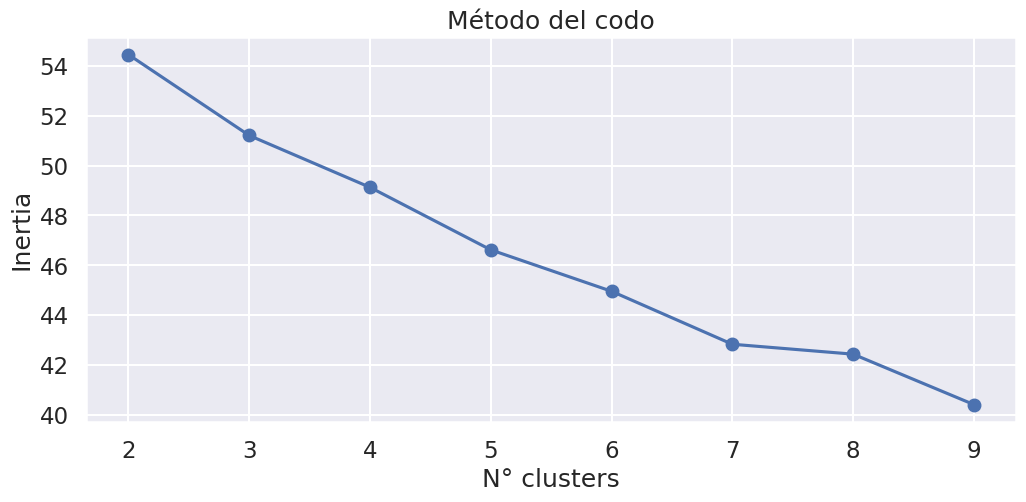

In [48]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, dtw_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

#### GAK

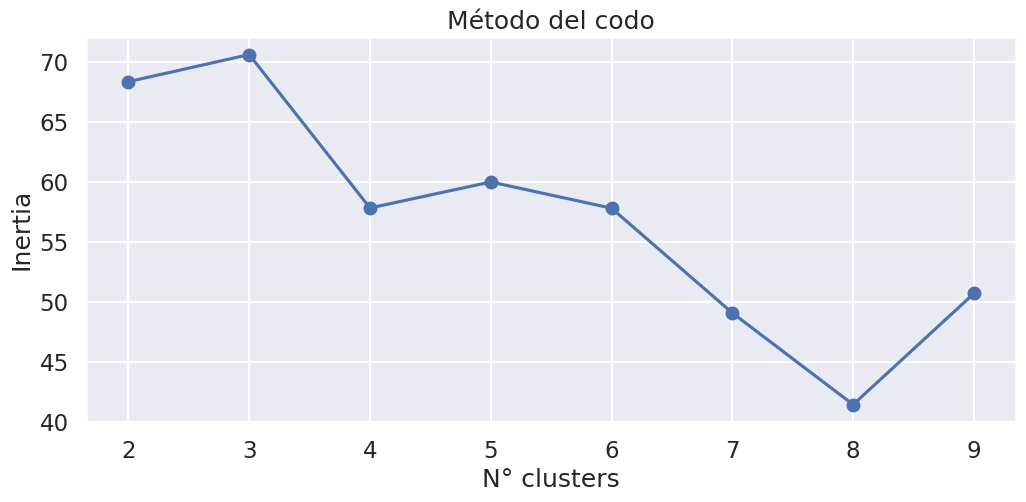

In [49]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(n_clusters, gak_inertia_list, marker='o')
ax.set_title('Método del codo')
ax.set_xlabel('N° clusters')
ax.set_ylabel('Inertia')

plt.show()

### Mejor modelo

In [50]:
seed = 42 
np.random.seed(seed)

dba_km = TimeSeriesKMeans(n_clusters=5,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)

_, y_pred, _ = bench_k_means(kmeans=dba_km, name="dba_minmax", data=X_train, n_clusters=5)

dba_minmax		5	1.239	47.711		0.000


### Centros de clústers

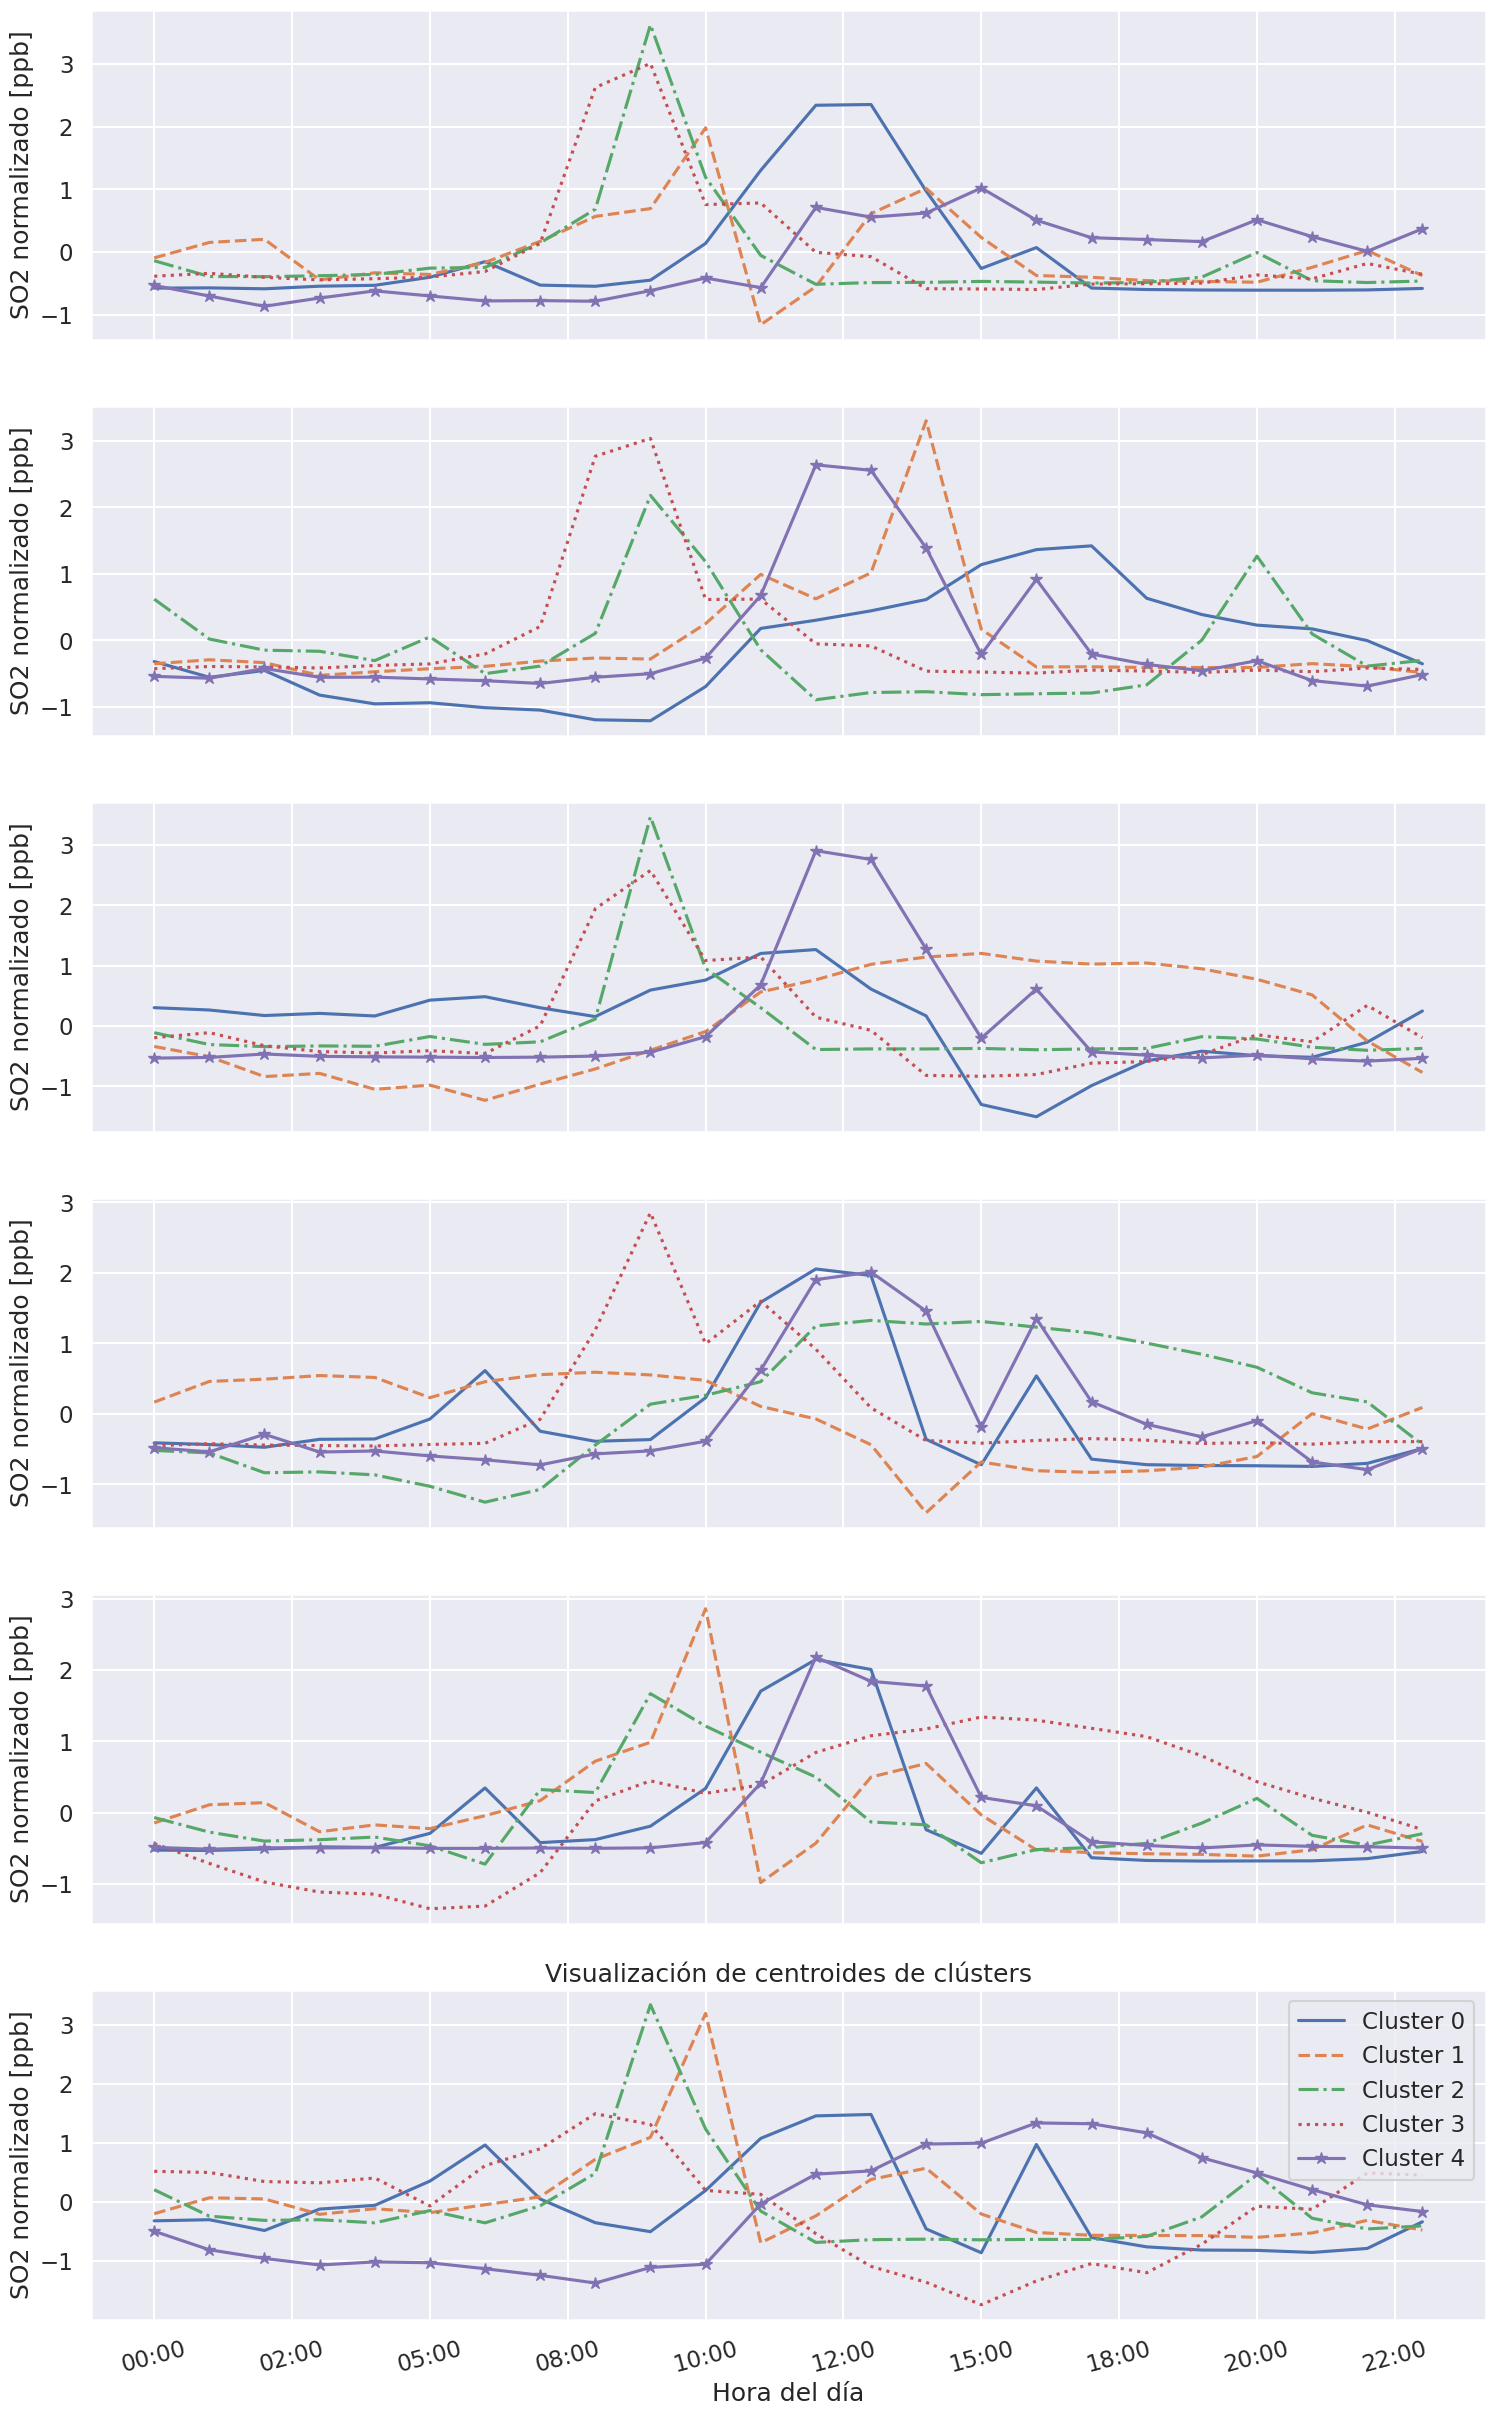

In [54]:
plot_cluster_centers(dba_km.cluster_centers_, ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4',
                                                'Cluster 5', 'Cluster 6','Cluster 7','asd'], "SO2 normalizado [ppb]")

### Distribución de clústers

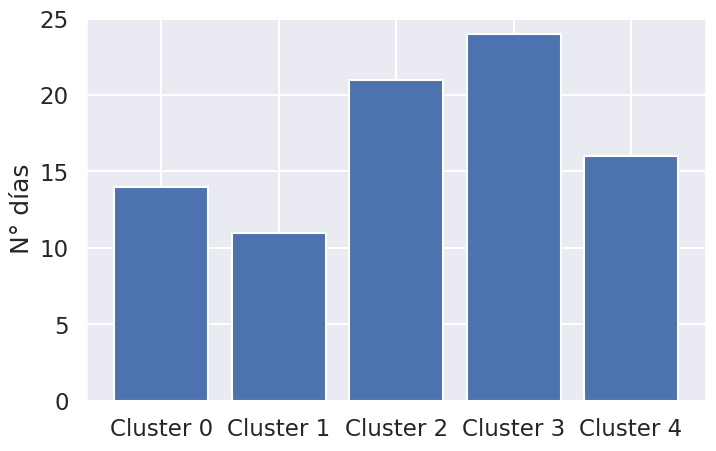

In [52]:
fig, axs = plt.subplots(figsize=(8,5))

cluster_distribution(y_pred)

plt.show()